### IMPORTING LIBRARIES, DATA

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

In [2]:
# Loading Dataset
df = pd.read_csv('/content/claims_copy.csv', skiprows=0, parse_dates=['gwp_from','acc_month', 'rep_date'])
date = df['gwp_from']
print(df.shape)
df.head()

(20516, 11)


,country,insurance_group,s2model,gwp_from,acc_month,rep_date,paid,reserved,incurred,claim_count,state
0,DE,Household,prop,2018-02-28,2018-02-28,2018-02-28,0.0,2000.00,2000.00,1,IN PROGRESS
1,DE,Household,prop,2018-02-28,2018-02-28,2018-03-31,0.0,2000.00,2000.00,1,IN PROGRESS
2,DE,Household,prop,2018-02-28,2018-02-28,2018-04-30,0.0,2386.75,2386.75,1,IN PROGRESS
3,DE,Household,prop,2018-02-28,2018-02-28,2018-05-31,0.0,2386.75,2386.75,1,IN PROGRESS
4,DE,Household,prop,2018-02-28,2018-02-28,2018-06-30,0.0,2386.75,2386.75,1,IN PROGRESS


### HEATMAP

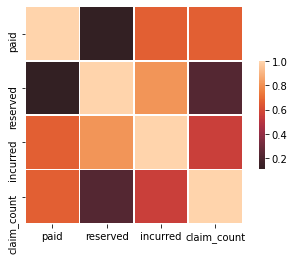

In [3]:
corr = df.corr()

# Draw the heatmap
sns.heatmap(corr, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### PREPROCESSING

In [4]:
#Checking missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
# Missing values statistics
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 11 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
gwp_from,851,4.1
country,96,0.5
insurance_group,96,0.5
s2model,96,0.5


In [5]:
# This will turn all of the string value into category values
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [6]:
# converting Category Columns to numeric
labelencoder = LabelEncoder()

for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)
        # Encoding
        df[label] = labelencoder.fit_transform(df[label].astype(str))

country
insurance_group
s2model
gwp_from
acc_month
rep_date
state


### GETTING DATA READY TO TRAIN ON A MODEL

In [7]:
# Splitting in X and y
X = df.drop(['country',	'insurance_group', 's2model',	'gwp_from',	'acc_month',	'rep_date','state', 'incurred'], axis=1)
y = df['incurred']

In [22]:
# Spliting into training and test data
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size =0.4)
X_train_date, X_test_date= train_test_split(date, test_size =0.4, shuffle=False)

### TRAINING AN XGBOOST

In [23]:
best_model = XGBRegressor(colsample_bytree= 0.7,
                           learning_rate= 0.003,
                            max_depth= 5,
                            min_child_weight= 4,
                           n_estimators= 1000,
                           nthread=4,
                           objective= 'reg:linear',
                           silent= 1,
                           subsample= 0.7)
model = best_model.fit(X_train, y_train)

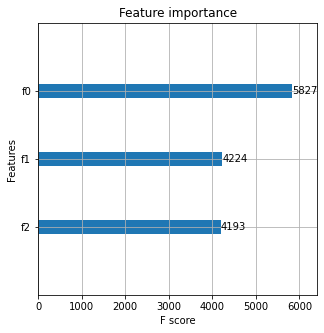

In [24]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [25]:
model.score(X_test, y_test)

0.9964564964824894

In [26]:
# Creating function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {"Training Mean Absolute Error": mean_absolute_error(y_train, train_preds),
              "Test Mean Absolute Error": mean_absolute_error(y_test, test_preds),
              "Training R^2 score": r2_score(y_train, train_preds),
              "Test data R^2 score": r2_score(y_test, test_preds)}
    return scores
# Evaluating our model
print(show_scores(model))

{'Training Mean Absolute Error': 338.0313496813587, 'Test Mean Absolute Error': 526.5231550976499, 'Training R^2 score': 0.9993234136969923, 'Test data R^2 score': 0.9964564964824895}


## SAVING MODEL

In [28]:
# save the model to disk
import pickle

filename = 'finalized_model.sav'

# Uncomment the following line to save model on your local system
#pickle.dump(best_model, open(filename, 'wb'))

## LOADING THE SAVED MODEL

In [29]:
model = pickle.load(open("finalized_model.sav", "rb"))

### PREDICTING USING TRAINED MODEL

In [30]:
# Predictions
preds = best_model.predict(X_test)

In [31]:
cols_when_model_builds = model.get_booster().feature_names

In [32]:
print(cols_when_model_builds)

['f0', 'f1', 'f2']


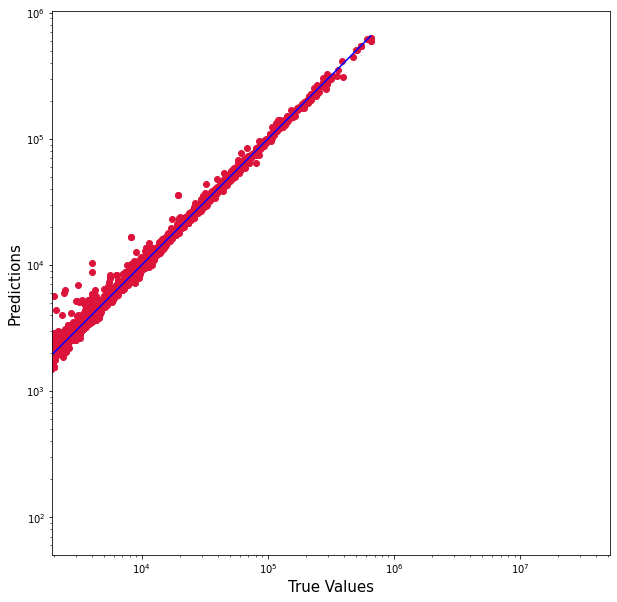

In [33]:

plt.figure(figsize=(10,10))
plt.scatter(y_test, preds, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(preds), max(y_test))
p2 = min(min(preds), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [35]:
mydata = [15000,1,0]

prediction = model.predict(mydata)
print(prediction)

[14975.162]
